# Problem Definition

The Language Identification (LangID) task consists in determining the natural language
that a text is written in. This is a necessary step in building the corpora on which LLM are
learned or, more simply, in determining which model to apply to a text.

# Data Collection


In [2]:
!curl https://pages.llf-paris.fr/~gwisniewski/assets/lid201-medium.tsv.bz2 --output /kaggle/working/lid201-small.tsv.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.6M  100 60.6M    0     0  51.0M      0  0:00:01  0:00:01 --:--:-- 51.0M


In [3]:
# unzip it 
!bunzip2 /kaggle/working/lid201-small.tsv.bz2


bunzip2: Output file /kaggle/working/lid201-small.tsv already exists.


In [4]:
 %config Completer.use_jedi = True


# Data Exploration & Cleaning

In [5]:
import pandas as pd
df = pd.read_csv("/kaggle/working/lid201-small.tsv",sep='\t',header=None)

df.columns = ['text','lang-script','unknown']
df.head(10)

,text,lang-script,unknown
0,V nariadení (ES) č. 1165 / 98 sa stanovuje spo...,slk_Latn,mt560
1,China is to impose the levy on imports of some...,eng_Latn,xlsum
2,Bomoko ya basaleli ya Nzambe ebɔndisaka mpe el...,lin_Latn,mt560
3,Танкетка — лёгкая баявая гусенічная адна- або ...,bel_Cyrl,lti
4,"The series will air early next year, ahead of ...",eng_Latn,xlsum
5,Decyzja 20 / 3 / 9.10.2011 komisji ds. kredytu...,pol_Latn,mt560
6,"c) Все оперативные сводки, публикуемые в перио...",rus_Cyrl,mt560
7,एप्रिल 2016 मध्ये कोबीनं आपली निवृत्ती जाहीर क...,mar_Deva,xlsum
8,Táto smernica začlenila do práva Spoločenstva ...,slk_Latn,mt560
9,"Saxara ximicheski chistыe, krome saxarozы, lak...",uzn_Latn,til


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959099 entries, 0 to 959098
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         959099 non-null  object
 1   lang-script  959099 non-null  object
 2   unknown      959099 non-null  object
dtypes: object(3)
memory usage: 22.0+ MB


In [7]:
# language and script columns
df[['lang', 'script']] = df['lang-script'].str.split('_', expand=True)
df.head()



,text,lang-script,unknown,lang,script
0,V nariadení (ES) č. 1165 / 98 sa stanovuje spo...,slk_Latn,mt560,slk,Latn
1,China is to impose the levy on imports of some...,eng_Latn,xlsum,eng,Latn
2,Bomoko ya basaleli ya Nzambe ebɔndisaka mpe el...,lin_Latn,mt560,lin,Latn
3,Танкетка — лёгкая баявая гусенічная адна- або ...,bel_Cyrl,lti,bel,Cyrl
4,"The series will air early next year, ahead of ...",eng_Latn,xlsum,eng,Latn


<Axes: xlabel='lang'>

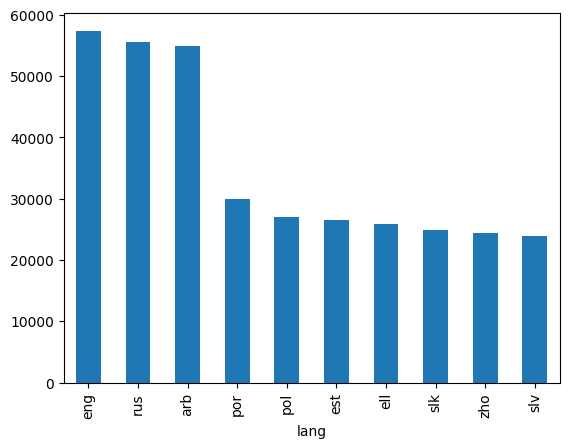

In [8]:
df['lang'].value_counts().head(10).plot(kind='bar')

<Axes: xlabel='script'>

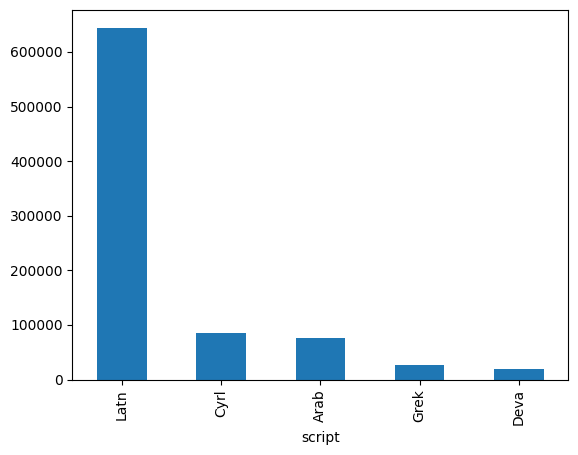

In [9]:
df['script'].value_counts().head(5).plot(kind="bar")

# Feature Engineering
The features generally considered for this task are based on 3-gram of characters: the
sentence “abcde” is represented by the one-hot encoding or tf.idf encoding of abc ,
bcd , cde

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1,shuffle=True)

print("Train size: ", len(train_set))
print("Test size : ", len(test_set))

Train size:  863189
Test size :  95910


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


# if max_features is set to = 100 000 accuracy => 87%
vectorizer  = TfidfVectorizer(lowercase=True,
                              analyzer='char',
                              max_features=20000,
                              ngram_range=(3,3),
                              min_df=5)

vectorizer.get_params()

{'analyzer': 'char',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 20000,
 'min_df': 5,
 'ngram_range': (3, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [12]:
X_train = vectorizer.fit_transform(train_set['text'])
X_test  = vectorizer.transform(test_set['text'])

print(X_train.shape)
print(X_test.shape)

(863189, 20000)
(95910, 20000)


In [13]:
import numpy as np

y_train = np.array(train_set['lang'])
y_test  = np.array(test_set['lang'])

print("shape of y_train (n_samples,)",y_train.shape)
print("shape of y_test (n_samples,)",y_test.shape)

shape of y_train (n_samples,) (863189,)
shape of y_test (n_samples,) (95910,)


In [14]:
from sklearn.linear_model import LogisticRegression


# Classifier initiation
lr_clf = LogisticRegression(solver="saga", # sag’ and ‘saga’ are faster for large datasets
                            penalty="l2",
                            max_iter=100,
                            C=6.0,
                            random_state=7,
                            verbose=1,
                           )


print("Hyperparameters:")
lr_clf.get_params()

Hyperparameters:


{'C': 6.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 7,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 1,
 'warm_start': False}

In [15]:
# training classifier
lr_clf.fit(X_train[:50000], y_train[:50000])

max_iter reached after 358 seconds


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished


LogisticRegression(C=6.0, random_state=7, solver='saga', verbose=1)

In [16]:
from sklearn.metrics import (

    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)


test_pred  = lr_clf.predict(X_test)

print("The accuracy score:")
print(accuracy_score(y_test,test_pred))


The accuracy score:
0.9144927536231884


In [17]:
from sklearn.metrics import classification_report

y_pred = lr_clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
filtered_df = report_df[report_df['f1-score'] <= 0.7]

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
list_lang = filtered_df.index.tolist()

df_lang2keep = df[df['lang'].isin(list_lang)]


grouped = df_lang2keep.groupby(['script']).size().reset_index(name='count')
grouped

,script,count
0,Arab,2724
1,Cyrl,1590
2,Deva,1595
3,Hans,8308
4,Hant,16537
5,Hebr,5
6,Jpan,7068
7,Laoo,200
8,Latn,15781
9,Olck,69


The following scripts correspond to cases where the model's accuracy is below 70%.



/tmp/ipykernel_10/358923950.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='script', y='count', palette='Set2')


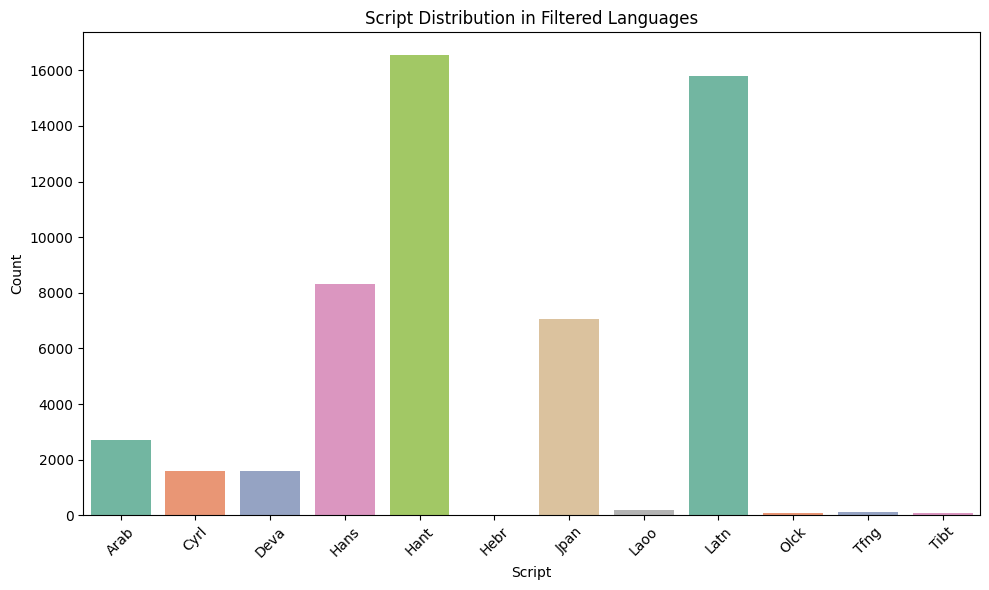

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='script', y='count', palette='Set2')

# Add titles and labels
plt.title('Script Distribution in Filtered Languages')
plt.xlabel('Script')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


these are the scripts which the model have less than 50% in accuracy 

In [20]:
df_lang2keep[df_lang2keep['script'] == 'Latn']['lang'].unique()

array(['zsm', 'jav', 'bos', 'scn', 'sun', 'kbp', 'szl', 'ltz', 'fuv',
       'fur', 'kab', 'min', 'grn', 'wol', 'vec', 'fao', 'nno', 'ast',
       'srd', 'dik', 'ltg', 'oci', 'dyu', 'lmo', 'bjn', 'ban', 'isl',
       'cjk', 'lij', 'kmr', 'glg', 'ace', 'taq', 'crh', 'lim', 'kac',
       'bug', 'nus', 'bam', 'knc', 'kea', 'sot'], dtype=object)

**this is the list of languages written in Laten thet the model failed to get an accuracy more than 70%**:


zsm: Standard Malay (Malaysian), jav: Javanese, bos: Bosnian, scn: Sicilian, sun: Sundanese, szl: Silesian, ltz: Luxembourgish , ssw: Swati (Swazi) , fuv: Nigerian Fulfulde, fur: Friulian, kab: Kabyle (a Berber language), min: Minangkabau , wol: Wolof, vec: Venetian, fao: Faroese, nno: Norwegian Nynorsk, ast: Asturian, gla: Scottish Gaelic, srd: Sardinian, dik: Southwestern Dinka, ltg: Latgalian, oci: Occitan, dyu: Dyula, lmo: Lombard, bjn: Banjar, ban: Balinese, isl: Icelandic, cjk: Chokwe, lij: Ligurian, kmr: Northern Kurdish (Kurmanji), glg: Galician, ace: Acehnese, taq: Tamasheq (Tuareg Berber), crh: Crimean Tatar, lim: Limburgish, kac: Kachin (also known as Jingpho), bug: Buginese, nus: Nuer, bam: Bambara, knc: Central Kanuri, kea: Cape Verdean Creole, sot: Southern Sotho

## The Importance of Texts Length in Prediction

In [21]:
train_set['length'] = train_set['text'].str.len()

In [22]:
longer_df  = train_set[train_set['length'] > train_set['length'].median().item()]
shorter_df = train_set[train_set['length'] <= train_set['length'].median().item()]

X_long  = vectorizer.transform(longer_df['text'])
X_short = vectorizer.transform(shorter_df['text'])

y_long  = longer_df['lang'].to_list()
y_short = shorter_df['lang'].to_list()

y_long_pred  = lr_clf.predict(X_long)
y_short_pred = lr_clf.predict(X_short)

print("The Accuracy Scores:")

print(accuracy_score(y_long,y_long_pred))
print(accuracy_score(y_short,y_short_pred))

The Accuracy Scores:
0.9715115738588825
0.8658239953431321


## Confusion Matrix:

In [23]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_long,y_long_pred)

print(cm)

[[  12    0    0 ...    0   15    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...  991    0    1]
 [   0    0    0 ...    0  801    0]
 [   0    0    0 ...    0    0 2877]]


In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score_ = precision_score(y_long,y_long_pred,average=None,zero_division=False)
recall_score_    = recall_score(y_long,y_long_pred,average=None,zero_division=False)


In [25]:
classes = longer_df['lang'].unique()
class_names = sorted(classes)

metrics_df = pd.DataFrame({
'Language':  class_names,
'Precision': precision_score_,
'Recall':    recall_score_
})


# Every time the model predicted a sentence is "ace", it was correct.
# But the model missed most of the actual "ace" examples.
metrics_df.iloc[0]

Language          ace
Precision         1.0
Recall       0.109091
Name: 0, dtype: object

In [26]:
metrics_df

,Language,Precision,Recall
0,ace,1.000000,0.109091
1,acm,0.000000,0.000000
2,aeb,0.000000,0.000000
3,afr,0.983562,0.980048
4,ajp,1.000000,0.081081
...,...,...,...
188,yor,0.991614,0.982857
189,yue,0.000000,0.000000
190,zho,0.638531,0.867776
191,zsm,0.798604,0.415672


In [30]:
latin_df     = longer_df[longer_df['script']=='Latn']     # 309540 examples
non_latin_df = longer_df[~(longer_df['script']=='Latn')]  # 120499 examples

### Latin Script

In [36]:
X_latin_train , X_latin_test, y_latin_train, y_latin_test    = train_test_split(latin_df['text'],latin_df['lang'],test_size=0.2,random_state=7)

X_train_latin_tfidf = vectorizer.fit_transform(X_latin_train)
X_test_latin_tfidf = vectorizer.transform(X_latin_test)

In [38]:
latin_model = LogisticRegression(solver='saga', penalty='l2', C=6.0,max_iter=1, random_state=7)
latin_model.fit(X_train_latin_tfidf, y_latin_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=6.0, max_iter=1, random_state=7, solver='saga')

### Non Latin Script

In [37]:
X_nlat_train, X_nlat_test, y_nlat_train, y_nlat_test = train_test_split(non_latin_df['text'],non_latin_df['lang'],test_size=0.2,random_state=7)

X_train_non_latin_tfidf = vectorizer.fit_transform(X_nlat_train)
X_test_non_latin_tfidf  = vectorizer.transform(X_nlat_test)

In [39]:
non_latin_model = LogisticRegression(solver='saga', penalty='l2', C=6.0,max_iter=1, random_state=7)
non_latin_model.fit(X_train_non_latin_tfidf, y_nlat_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=6.0, max_iter=1, random_state=7, solver='saga')

### Prediction

In [44]:
latin_test_predictions     = latin_model.predict(X_test_latin_tfidf)
non_latin_test_predictions = non_latin_model.predict(X_test_non_latin_tfidf)

latin_test_accuracy     = accuracy_score(y_latin_test, latin_test_predictions)
non_latin_test_accuracy = accuracy_score(y_nlat_test,non_latin_test_predictions)

print(latin_test_accuracy)
print(non_latin_test_accuracy)

0.9809219446058494
0.9879258122069624


In [46]:
latin_df_results = pd.DataFrame({
'language': y_latin_test,
'predictions': latin_test_predictions
})
non_latin_df_results = pd.DataFrame({
'language': y_nlat_test,
'predictions': non_latin_test_predictions
})
combined_df = pd.concat([latin_df_results, non_latin_df_results])
combined_accuracy = accuracy_score(combined_df['language'],combined_df['predictions'])
print(f"Latin alphabet accuracy : {latin_test_accuracy * 100:.8f} %")
print(f"Non-latin alphabet accuracy : {non_latin_test_accuracy * 100:.8f} %")
print(f"Combined accuracy : {combined_accuracy * 100:.8f} %")

Latin alphabet accuracy : 98.09219446 %
Non-latin alphabet accuracy : 98.79258122 %
Combined accuracy : 98.28834377 %


## Conclustion

If the dataset is divided into two subsets—one containing Latin-script data and the other non-Latin-script data—then we can train two separate models accordingly. This approach can lead to improved accuracy, as each model is specialized for its respective script type. During inference, we simply detect the script of the input and route it to the appropriate model.

In [ ]:
i